In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import barycentric_interpolate
from numpy import linalg as la
from scipy.optimize import root
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

# Setup

In [3]:
def cheb(N):
    x = np.cos((np.pi/N)*np.linspace(0,N,N+1))
    x.shape = (N+1,1)
    lin = np.linspace(0,N,N+1)
    lin.shape = (N+1,1)
    
    c = np.ones((N+1,1))
    c[0], c[-1] = 2., 2.
    c = c*(-1.)**lin
    X = x*np.ones(N+1) # broadcast along 2nd dimension (columns)
    
    dX = X - X.T
    
    D = (c*(1./c).T)/(dX + np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    x.shape = (N+1,)
    # Here we return the differentiation matrix and the Chebyshev points,
    # numbered from x_0 = 1 to x_N = -1
    return D, x

# Problem 1

Use the differentiation matrix to numerically approximate the derivative of $u(x) = e^{x}\cos(6x)$ on a grid of $N$ Chebychev points where N=6, 8, and 10.
Then use barycentric interpolation scipy.interpolate.barycentric_interpolate to approximate u' on a grid of 100 evenly spaced points.

Graphically compare your approximation to the exact derivative.
Note that this convergence would not be occurring if the collocation points were equally spaced.

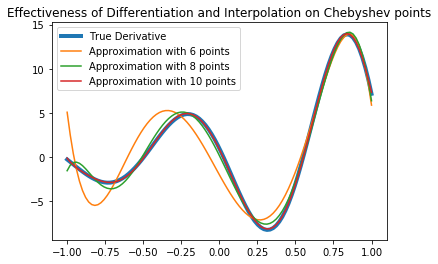

In [4]:
ns = [6,8,10]
domain = np.linspace(-1,1,100)

u = lambda x : np.exp(x) * np.cos(6 * x)
du = lambda x : np.exp(x) * (np.cos(6 * x) - 6 * np.sin(6 * x))
plt.plot(domain, du(domain), linewidth=4, label="True Derivative")

for n in ns:
    # Get differentiation matrix and Chebyshev points for given n
    D, x = cheb(n)
    
    # for the first derivative, L is simply D
    U_n = D @ u(x)
    
    U = barycentric_interpolate(x,U_n,domain)
    plt.plot(domain, U,label="Approximation with {} points".format(n))


plt.legend()
plt.title("Effectiveness of Differentiation and Interpolation on Chebyshev points")
plt.show()
    

# Problem 2

Use the pseudospectral method to solve the boundary value problem
\begin{align*}
&{ } u'' = e^{2x}, \quad x \in (-1,1), \\
&{ } u(-1) = 0, \quad u(1) = 0.
\end{align*}

Use $N=8$ in the \li{cheb(N)} method and use barycentric interpolation to approximate $u$ on 100 evenly spaced points.
Compare your numerical solution with the exact solution.

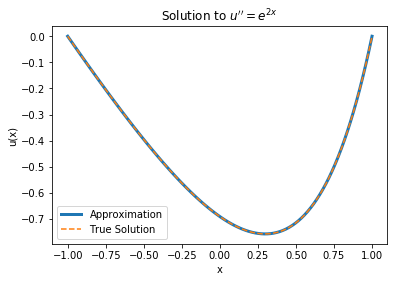

In [5]:
# Define f
f = lambda x : np.exp(2 * x)

# Get D2, F
D, x = cheb(8)
D2 = np.dot(D,D)
F = f(x)

# Fix endpoints
D2[0,:], D2[-1,:] = 0, 0
D2[0,0], D2[-1,-1] = 1, 1
F[0], F[-1] = 0, 0

# Solve for U
U_n = np.linalg.solve(D2, F)

# Barycentric interpolation
domain = np.linspace(-1,1,100)
U = barycentric_interpolate(x,U_n,domain)

# Compare to true solution
u = lambda x : (-np.cosh(2) - np.sinh(2) * x + np.exp(2 * x))/4

plt.plot(domain, U, linewidth=3, label="Approximation")
plt.plot(domain, u(domain),'--', label="True Solution")
plt.legend()
plt.title("Solution to $u'' = e^{2x}$")
plt.ylabel("u(x)")
plt.xlabel("x")
plt.show()

# Problem 3

Use the pseudospectral method to solve the boundary value problem
\begin{align*}
&{ } u'' + u' = e^{3x}, \quad x \in (-1,1), \\
&{ } u(-1) = 2, \quad u(1) = -1.
\end{align*}

Use $N=8$ in the \li{cheb(N)} method and use barycentric interpolation to approximate $u$ on 100 evenly spaced points.

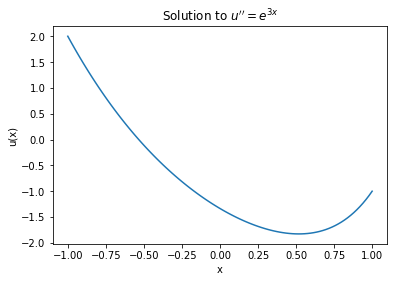

In [6]:
# Define f
f = lambda x : np.exp(3 * x)

# Get L, F
D, x = cheb(8)
D2 = np.dot(D,D)
F = f(x)

L = D2 + D


# Fix endpoints
L[0,:], L[-1,:] = 0, 0
L[0,0], L[-1,-1] = 1, 1
F[0], F[-1] = -1, 2

# Solve for U
U_n = np.linalg.solve(L, F)

# Barycentric interpolation
domain = np.linspace(-1,1,100)
U = barycentric_interpolate(x,U_n,domain)


plt.plot(domain, U)
plt.title("Solution to $u'' = e^{3x}$")
plt.ylabel("u(x)")
plt.xlabel("x")
plt.show()

# Problem 4

Use the pseudospectral method to solve the boundary value problem
\begin{align*}
&{ } u'' = \lambda\sinh(\lambda u), \quad x \in (0,1), \\
&{ } u(0) = 0, \quad u(1) = 1
\end{align*}
for several values of $\lambda$: $\lambda = 4, 8, 12$. 
Begin by transforming this BVP onto the domain $-1<x<1$.
Use $N=20$ in the cheb(N) method and use barycentric interpolation to approximate $u$ on 100 evenly spaced points.

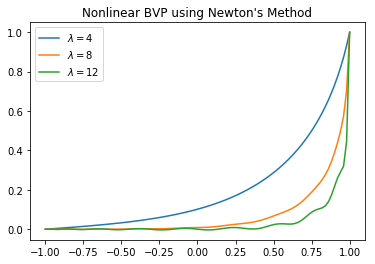

In [32]:
D, x = cheb(20)
D2 = np.dot(D,D)


# u(x) = v(2x - 1)
# u'(x) = 2v'(2x - 1)
# u"(x) = 4v"(2x - 1)
domain = np.linspace(-1,1,101)

for l in [4,8,12]:
    
    def F(U):
        return np.hstack((U[0] - 1,(4 * D @ D @ U - l * np.sinh( l * U ))[1:-1],U[-1]))
    
    solution = root(F,np.ones_like(x)).x
    U = barycentric_interpolate(x,solution,domain)
    plt.plot(domain, U,label="$\lambda = {}$".format(l))

plt.title("Nonlinear BVP using Newton's Method")
plt.legend()
plt.show()
    
    

# Problem 5

Find the function $y(x)$ that satisfies $y(-1) = 1$, $y(1) = 7$, and whose surface of revolution (about the $x$-axis) minimizes surface area.
Compute the surface area, and plot the surface. \label{prob:pseudospectral1_revision:minimal_surface}
Use $N=50$ in the cheb(N) method and use barycentric interpolation to approximate $u$ on 100 evenly spaced points.


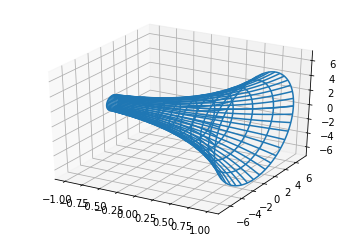

In [49]:
D, x = cheb(50)

def F(Y):
    return np.hstack((Y[0] - 7, ( Y * (D @ D@Y) - (D@Y)**2- np.ones_like(Y))[1:-1] , Y[-1] - 1))

Y_n = root(F,3 * x + 4).x

domain = np.linspace(-1,1,100)
barycentric = barycentric_interpolate(x,Y_n,domain) #This is the output of barycentric_interpolate()

lin = np.linspace(-1, 1, 100)
theta = np.linspace(0,2*np.pi,401)
X, T = np.meshgrid(lin, theta)
Y, Z = barycentric*np.cos(T), barycentric*np.sin(T)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
plt.show()


In [54]:
%matplotlib notebook